# Zadanie 4 — Analiza wrażliwości (SA) modeli: PDE i ODE
Cel:
1) Przeprowadzić analizę wrażliwości (Morris, Sobol) dla redukcji ODE i — jeśli dostępne — dla modelu PDE.  
2) Zidentyfikować najbardziej wpływowe parametry oraz (poprzez metryki) dynamiczne zmienne wyjściowe.  
3) Zasugerować uproszczenie modeli na bazie wyników SA.  
Wyniki: wykresy → `figs/`, tabele/CSV → `out/`.

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass, asdict

# Tworzymy katalogi na wyniki
Path("fig").mkdir(exist_ok=True)
Path("out").mkdir(exist_ok=True)

# SALib (Morris, Sobol)
SALIB_OK = True
try:
    from SALib.sample import morris as morris_sample
    from SALib.analyze import morris as morris_analyze
    from SALib.sample import saltelli
    from SALib.analyze import sobol
except Exception as e:
    SALIB_OK = False
    print("Uwaga: SALib nie jest dostępne. Morris/Sobol będą pominięte. Treść błędu:", e)

def savefig_fig(fname, dpi=160):
    if not str(fname).startswith("figs/"):
        fname = f"figs/{fname}"
    plt.savefig(fname, dpi=dpi, bbox_inches="tight")
    print(f"[Zapisano wykres] {fname}")

def save_json(obj, path):
    if not str(path).startswith("out/"):
        path = f"out/{path}"
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"[Zapisano JSON] {path}")


In [11]:
@dataclass
class ODEParams:
    rho_S: float = 0.04
    rho_R: float = 0.03
    K: float = 1.0
    alpha_S: float = 0.8
    alpha_R: float = 0.12
    sigma: float = 0.05
    delta: float = 0.1
    gamma_S: float = 0.02
    gamma_R: float = 0.02
    lam: float = 0.2
    beta: float = 0.0
    mu_max: float = 0.05
    C50: float = 0.2
    m_hill: int = 3
    dose_type: str = "bolus_periodic"
    dose_A: float = 1.0
    dose_period: float = 5.0
    infusion_rate: float = 0.0

def mu_of_C(C, mu_max, C50, m):
    Cn = max(C, 0.0)
    ratio = (Cn / (C50 + 1e-12))**m
    return mu_max * (ratio / (1.0 + ratio))

def dosing_term_exact(t, dt, period, A):
    tau = 0.01 * period
    t0 = (t // period) * period
    start, end = t0, t0 + tau
    overlap = max(0.0, min(t+dt, end) - max(t, start))
    return (A / tau) * (overlap / max(dt, 1e-12))

def ode_rhs(t, y, p: ODEParams, dt_for_dose):
    S, R, I, C = y
    N = S + R
    # logistyczny wzrost
    dS = p.rho_S * S * (1 - N/p.K) - p.alpha_S*C*S - p.gamma_S*I*S
    dR = p.rho_R * R * (1 - N/p.K) - p.alpha_R*C*R - p.gamma_R*I*R
    # indukcja oporności
    mu = mu_of_C(C, p.mu_max, p.C50, p.m_hill)
    dS -= mu * S
    dR += mu * S
    # odporność
    dI = p.sigma * N - p.delta * I
    # lek
    dC = - p.lam * C - p.beta * C * N
    if p.dose_type == "infusion_const":
        I_in = p.infusion_rate
    elif p.dose_type == "bolus_periodic":
        I_in = dosing_term_exact(t, dt_for_dose, p.dose_period, p.dose_A)
    else:
        I_in = 0.0
    dC += I_in
    return np.array([dS, dR, dI, dC], dtype=float)

# Prosta integracja na stałej siatce czasu (Euler-RK2 wystarczy dla SA; szybciej niż solve_ivp)
def simulate_ode_grid(p: ODEParams, y0, t_grid):
    dt = np.mean(np.diff(t_grid)) if len(t_grid) > 1 else 1e-2
    y = np.array(y0, dtype=float)
    Y = np.zeros((len(t_grid), 4), dtype=float)
    Y[0] = y
    for k in range(1, len(t_grid)):
        t = t_grid[k-1]
        # prosty Heun (RK2): predykcja + korekcja
        f1 = ode_rhs(t, y, p, dt)
        y_pred = y + dt*f1
        f2 = ode_rhs(t+dt, y_pred, p, dt)
        y = y + 0.5*dt*(f1+f2)
        y = np.maximum(y, 0.0)  # bez ujemnych
        Y[k] = y
    S, R, I, C = Y[:,0], Y[:,1], Y[:,2], Y[:,3]
    TB = S + R
    return {"t": t_grid, "S": S, "R": R, "I": I, "C": C, "TB": TB}

In [12]:
def compute_metrics_from_traj(traj):
    t = traj["t"]; TB = traj["TB"]; S = traj["S"]; R = traj["R"]; C = traj["C"]
    # metryki globalne
    TB_final = float(TB[-1])
    TB_min   = float(TB.min())
    t_half   = float(t[np.argmin(np.abs(TB - 0.5*TB[0]))]) if (TB <= 0.5*TB[0]).any() else float("nan")
    R_frac_final = float(R[-1] / max(TB[-1], 1e-12))
    C_AUC  = float(np.trapz(C, t))
    return {
        "TB_final": TB_final,
        "TB_min": TB_min,
        "t_half": t_half,
        "R_frac_final": R_frac_final,
        "C_AUC": C_AUC
    }

In [13]:
# Siatka czasowa zgodna z wcześniejszymi analizami
t_grid = np.linspace(0.0, 6.0, 301)
# IC z proporcji TB(0)
TB0 = 0.0465
S0, R0, I0, C0 = 0.9*TB0, 0.1*TB0, 0.02, 0.0
y0 = np.array([S0, R0, I0, C0], dtype=float)

p_base = ODEParams()  # wartości bazowe jak wcześniej
base_traj = simulate_ode_grid(p_base, y0, t_grid)
base_metrics = compute_metrics_from_traj(base_traj)
save_json({"base_params": asdict(p_base), "base_metrics": base_metrics}, "out/sa_ode_baseline.json")

[Zapisano JSON] out/sa_ode_baseline.json


/var/folders/6_/b9qmtg5j1pxcmnj2dxsbcd240000gn/T/ipykernel_56243/4160109053.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  C_AUC  = float(np.trapz(C, t))


In [14]:
# Lista parametrów i widełek (konserwatywnie wokół wartości bazowych)
param_names = [
    "rho_S", "rho_R", "K",
    "alpha_S", "alpha_R",
    "sigma", "delta", "gamma_S", "gamma_R",
    "lam", "beta",
    "mu_max", "C50"
]
# dolne i górne granice (proporcjonalnie)
bounds = {
    "rho_S": (0.02, 0.08),
    "rho_R": (0.01, 0.06),
    "K":     (0.5,  2.0),
    "alpha_S": (0.4, 1.2),
    "alpha_R": (0.05, 0.3),
    "sigma": (0.0, 0.1),
    "delta": (0.05, 0.2),
    "gamma_S": (0.0, 0.05),
    "gamma_R": (0.0, 0.05),
    "lam": (0.05, 0.5),
    "beta": (0.0, 0.2),
    "mu_max": (0.0, 0.1),
    "C50": (0.05, 0.5)
}

# SALib problem dict
problem = {
    "num_vars": len(param_names),
    "names": param_names,
    "bounds": [bounds[n] for n in param_names]
}
save_json({"param_names":param_names, "bounds":bounds}, "out/sa_problem_ode.json")

[Zapisano JSON] out/sa_problem_ode.json


In [15]:
def eval_ode_params(x_row, metric="TB_final"):
    # x_row: 1D array w kolejności param_names
    p = ODEParams(**asdict(p_base))
    for name, val in zip(param_names, x_row):
        setattr(p, name, float(val))
    traj = simulate_ode_grid(p, y0, t_grid)
    m = compute_metrics_from_traj(traj)
    return m[metric]

/var/folders/6_/b9qmtg5j1pxcmnj2dxsbcd240000gn/T/ipykernel_56243/4160109053.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  C_AUC  = float(np.trapz(C, t))


[Zapisano] out/morris_ode_TB_final.csv
[Zapisano wykres] figs/morris_ode_TB_final.png


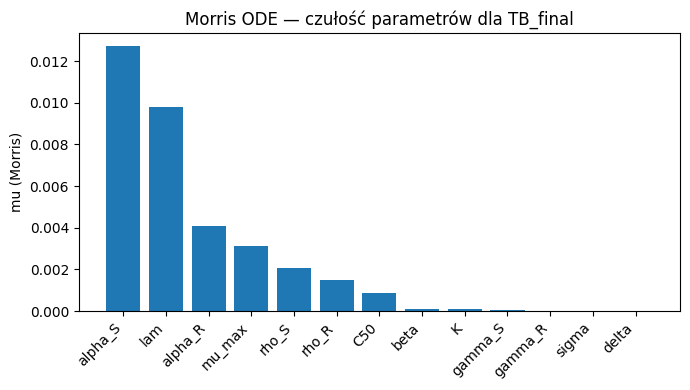

[t_half] Odrzucono 131/600 trajektorii z NaN/Inf (zachowano 469).
[Zapisano] out/morris_ode_t_half.csv
[Zapisano wykres] figs/morris_ode_t_half.png


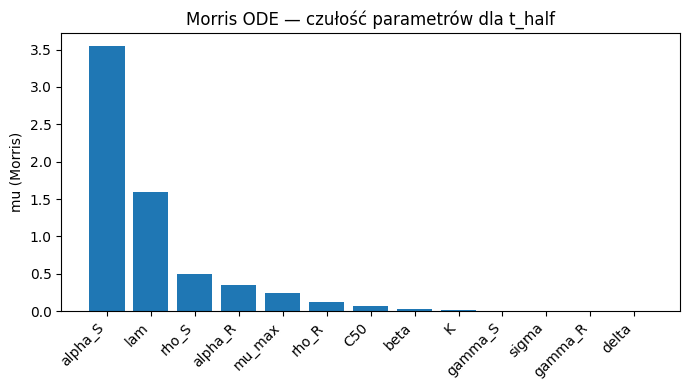

[Zapisano] out/morris_ode_R_frac_final.csv
[Zapisano wykres] figs/morris_ode_R_frac_final.png


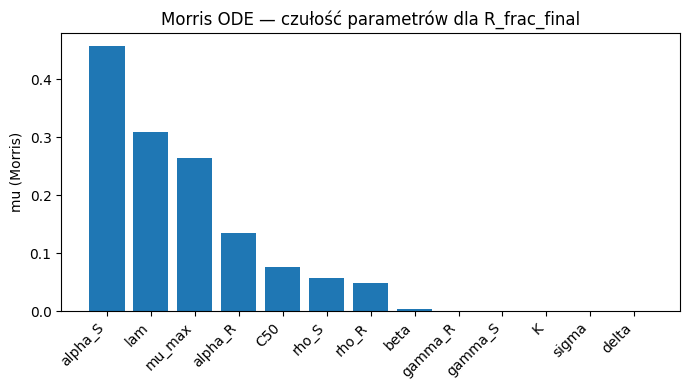

[Zapisano] out/morris_ode_C_AUC.csv
[Zapisano wykres] figs/morris_ode_C_AUC.png


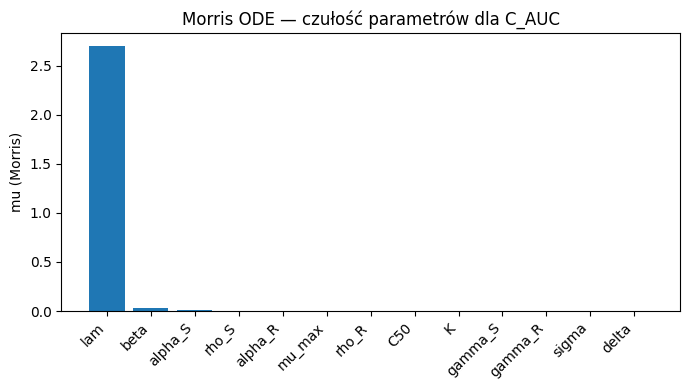

[Zapisano JSON] out/morris_ode_all.json


In [16]:
if not SALIB_OK:
    print("Pominięto Morris ODE — SALib niedostępny.")
else:
    import pandas as pd

    # 1) Próbkowanie Morris (zgodnie z wersją SALib bez grid_jump w sample)
    N = 600          # liczba trajektorii (możesz zmniejszyć dla szybkości)
    num_levels = 6
    X_all = morris_sample.sample(
        problem,
        N=N,
        num_levels=num_levels,
        optimal_trajectories=None,
        local_optimization=True,
        seed=42
    )

    D = problem["num_vars"]
    traj_size = D + 1
    assert X_all.shape[0] % traj_size == 0, "Rozmiar próbki Morris nie jest wielokrotnością (D+1)."
    n_traj = X_all.shape[0] // traj_size

    # Funkcja sanityzująca dla JSON
    def _json_sanitize(obj):
        if isinstance(obj, dict):
            return {k: _json_sanitize(v) for k, v in obj.items()}
        if isinstance(obj, (list, tuple, np.ndarray)):
            out = []
            for x in obj:
                if isinstance(x, float) and (np.isnan(x) or np.isinf(x)):
                    out.append(None)
                else:
                    out.append(_json_sanitize(x))
            return out
        if isinstance(obj, float) and (np.isnan(obj) or np.isinf(obj)):
            return None
        return obj

    metrics = ["TB_final", "t_half", "R_frac_final", "C_AUC"]
    results = {}

    for metric in metrics:
        # 2) Ewaluacja wyjścia dla wszystkich punktów, bez filtrowania
        Y_all = np.array([eval_ode_params(x, metric=metric) for x in X_all], dtype=float)

        # 3) Podział na trajektorie i maska "dobrych" trajektorii (bez NaN/Inf)
        Y_traj = Y_all.reshape(n_traj, traj_size)
        X_traj = X_all.reshape(n_traj, traj_size, D)

        good_traj_mask = np.all(np.isfinite(Y_traj), axis=1)
        kept = int(good_traj_mask.sum())
        dropped = int((~good_traj_mask).sum())
        if dropped > 0:
            print(f"[{metric}] Odrzucono {dropped}/{n_traj} trajektorii z NaN/Inf (zachowano {kept}).")

        if kept < 5:
            print(f"[{metric}] Zbyt mało pełnych trajektorii po odfiltrowaniu (kept={kept}). Pomijam analizę Morris.")
            continue

        X = X_traj[good_traj_mask].reshape(-1, D)
        Y = Y_traj[good_traj_mask].reshape(-1)

        # 4) Analiza Morris na "pełnych" trajektoriach
        Si = morris_analyze.analyze(
            problem, X, Y,
            conf_level=0.95,
            print_to_console=False,
            num_levels=num_levels
        )
        results[metric] = Si

        # 5) CSV z μ* i σ
        df = pd.DataFrame({
            "param": problem["names"],
            "mu_star": Si["mu_star"],
            "mu_star_conf": Si["mu_star_conf"],
            "sigma": Si["sigma"]
        })
        out_csv = f"out/morris_ode_{metric}.csv"
        df.to_csv(out_csv, index=False)
        print("[Zapisano]", out_csv)

        # 6) Wykres słupkowy μ*
        order = np.argsort(Si["mu_star"])[::-1]
        plt.figure(figsize=(7,4))
        plt.bar(np.array(problem["names"])[order], np.array(Si["mu_star"])[order])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel(f"mu (Morris)")
        plt.title(f"Morris ODE — czułość parametrów dla {metric}")
        plt.tight_layout()
        savefig_fig(f"morris_ode_{metric}.png")
        plt.show()

    # 7) JSON bez NaN
    serial = {m: {k: (np.array(v).tolist() if hasattr(v, "__len__") else float(v))
                  for k, v in results[m].items()} for m in results}
    save_json(_json_sanitize(serial), "out/morris_ode_all.json")

/var/folders/6_/b9qmtg5j1pxcmnj2dxsbcd240000gn/T/ipykernel_56243/3775155622.py:9: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X = saltelli.sample(problem, N=M, calc_second_order=True)
/var/folders/6_/b9qmtg5j1pxcmnj2dxsbcd240000gn/T/ipykernel_56243/4160109053.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  C_AUC  = float(np.trapz(C, t))


[Zapisano] out/sobol_ode_TB_final.csv
[Zapisano wykres] figs/sobol_ode_TB_final.png


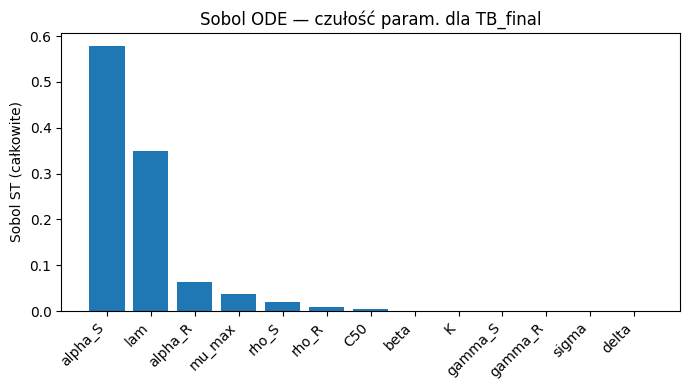

[Zapisano] out/sobol_ode_t_half.csv
[Zapisano wykres] figs/sobol_ode_t_half.png


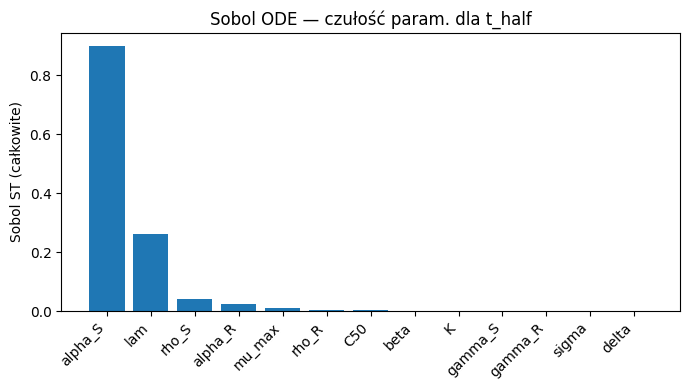

[Zapisano] out/sobol_ode_R_frac_final.csv
[Zapisano wykres] figs/sobol_ode_R_frac_final.png


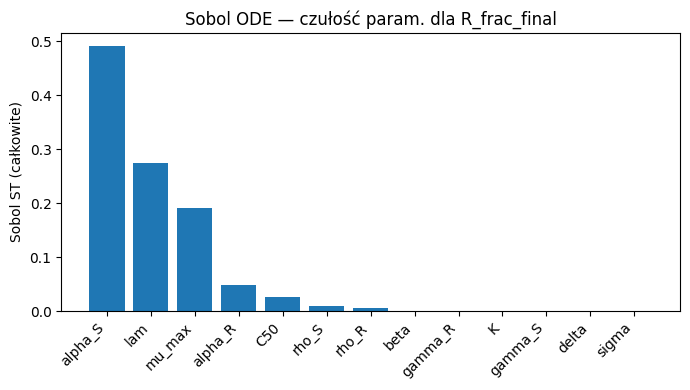

[Zapisano] out/sobol_ode_C_AUC.csv
[Zapisano wykres] figs/sobol_ode_C_AUC.png


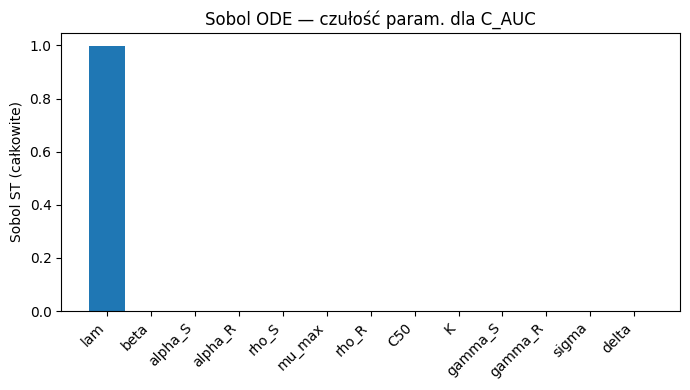

[Zapisano JSON] out/sobol_ode_lastmetric.json


In [17]:
# --- PATCH: Sobol ODE z obsługą NaN w t_half (bez psucia struktury Saltellego) ---
if not SALIB_OK:
    print("Pominięto Sobol ODE — SALib niedostępny.")
else:
    import pandas as pd

    D = problem["num_vars"]
    M = 256  # budżet próbkowania; zwiększ jeśli czas pozwala
    X = saltelli.sample(problem, N=M, calc_second_order=True)

    T_end = float(t_grid[-1])  # fallback dla t_half

    def safe_eval_metric(x_row, metric):
        """Zwraca zawsze liczbę skończoną dla t_half; pozostałe metryki przepuszcza."""
        val = eval_ode_params(x_row, metric=metric)
        if metric == "t_half":
            # jeśli nie osiągnięto 50% TB(0), ustaw t_half = T_end (konserwatywnie)
            if not np.isfinite(val):
                return T_end
        return float(val)

    def _json_sanitize(obj):
        if isinstance(obj, dict):
            return {k: _json_sanitize(v) for k, v in obj.items()}
        if isinstance(obj, (list, tuple, np.ndarray)):
            out = []
            for x in obj:
                if isinstance(x, float) and (np.isnan(x) or np.isinf(x)):
                    out.append(None)
                else:
                    out.append(_json_sanitize(x))
            return out
        if isinstance(obj, float) and (np.isnan(obj) or np.isinf(obj)):
            return None
        return obj

    metrics = ["TB_final", "t_half", "R_frac_final", "C_AUC"]
    sobol_last = None  # do zapisu ostatniej metryki (jak poprzednio)

    for metric in metrics:
        # policz Y bez naruszania struktury próbek
        Y = np.array([safe_eval_metric(x, metric) for x in X], dtype=float)

        # licz indeksy Sobola
        Si = sobol.analyze(problem, Y, calc_second_order=True, print_to_console=False)
        sobol_last = Si  # zapamiętaj ostatnią metrykę (do JSON jak wcześniej)

        # CSV: S1, ST + niepewności
        df = pd.DataFrame({
            "param": problem["names"],
            "S1": Si["S1"],
            "ST": Si["ST"],
            "S1_conf": Si["S1_conf"],
            "ST_conf": Si["ST_conf"]
        })
        out_csv = f"out/sobol_ode_{metric}.csv"
        df.to_csv(out_csv, index=False)
        print("[Zapisano]", out_csv)

        # Wykres — ST
        order = np.argsort(df["ST"].values)[::-1]
        plt.figure(figsize=(7,4))
        plt.bar(df["param"].values[order], df["ST"].values[order])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Sobol ST (całkowite)")
        plt.title(f"Sobol ODE — czułość param. dla {metric}")
        plt.tight_layout()
        savefig_fig(f"sobol_ode_{metric}.png")
        plt.show()

    # Zapis pełny JSON (ostatnia metryka, jak w Twojej wersji)
    if sobol_last is not None:
        save_json(_json_sanitize({
            "S1": sobol_last["S1"].tolist(),
            "ST": sobol_last["ST"].tolist(),
            "names": problem["names"]
        }), "out/sobol_ode_lastmetric.json")


In [18]:
# === PATCH: lepsze zestawienie ODE vs PDE i sensowniejsze uproszczenia ===
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

def load_top_morris(csv_path):
    if not Path(csv_path).exists():
        return None
    df = pd.read_csv(csv_path)
    # ochrona przed NaN
    for col in ["mu_star","sigma","mu_star_conf"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
    return df

def load_top_sobol(csv_path):
    if not Path(csv_path).exists():
        return None
    df = pd.read_csv(csv_path)
    for col in ["S1","ST","S1_conf","ST_conf"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
    # ujemne S1/ST traktuj jako 0 (artefakty estymacyjne)
    if "S1" in df: df["S1"] = df["S1"].clip(lower=0.0)
    if "ST" in df: df["ST"] = df["ST"].clip(lower=0.0)
    return df

summary = {"ode": {}, "pde": {}}

metrics_ode = ["TB_final","t_half","R_frac_final","C_AUC"]
metrics_pde = ["TB_final","t_half","R_frac_final"]

# zbieramy rankingi do raportu
for metric in metrics_ode:
    m_csv = Path(f"out/morris_ode_{metric}.csv")
    s_csv = Path(f"out/sobol_ode_{metric}.csv")
    if m_csv.exists():
        dfm = pd.read_csv(m_csv).sort_values("mu_star", ascending=False).head(6)
        summary["ode"][f"morris_{metric}"] = dfm.to_dict(orient="list")
    if s_csv.exists():
        dfs = pd.read_csv(s_csv).sort_values("ST", ascending=False).head(6)
        # ujemności do zera dla prezentacji
        for col in ["S1","ST"]:
            if col in dfs: dfs[col] = np.maximum(dfs[col], 0.0)
        summary["ode"][f"sobol_{metric}"] = dfs.to_dict(orient="list")

for metric in metrics_pde:
    m_csv = Path(f"out/morris_pde_{metric}.csv")
    s_csv = Path(f"out/sobol_pde_{metric}.csv")
    if m_csv.exists():
        dfm = pd.read_csv(m_csv).sort_values("mu_star", ascending=False).head(6)
        summary["pde"][f"morris_{metric}"] = dfm.to_dict(orient="list")
    if s_csv.exists():
        dfs = pd.read_csv(s_csv).sort_values("ST", ascending=False).head(6)
        for col in ["S1","ST"]:
            if col in dfs: dfs[col] = np.maximum(dfs[col], 0.0)
        summary["pde"][f"sobol_{metric}"] = dfs.to_dict(orient="list")

# --- Decyzja o uproszczeniach: przecięcie "mało istotnych" wg Sobola i Morrisa ---
low_sobol_all = defaultdict(set)
low_morris_all = defaultdict(set)

for metric in metrics_ode:
    s_csv = f"out/sobol_ode_{metric}.csv"
    m_csv = f"out/morris_ode_{metric}.csv"
    dfs = load_top_sobol(s_csv)
    dfm = load_top_morris(m_csv)
    if dfs is not None:
        ST = dfs["ST"].values
        # próg adaptacyjny: 1% maksymalnego ST w tej metryce
        thr_ST = 0.01 * (ST.max() if ST.size else 1.0)
        low_sobol = set(dfs.loc[dfs["ST"] <= thr_ST, "param"])
        low_sobol_all[metric] = low_sobol
    if dfm is not None:
        mu = dfm["mu_star"].values
        thr_mu = 0.01 * (mu.max() if mu.size else 1.0)
        low_morris = set(dfm.loc[dfm["mu_star"] <= thr_mu, "param"])
        low_morris_all[metric] = low_morris

# param do uproszczeń: występują jako "mało istotne" jednocześnie w Sobolu i Morrisie
# dla co najmniej jednej metryki; a parametry kiedykolwiek ważne pozostają chronione
proposed = set()
protected = set()

for metric in metrics_ode:
    s_csv = f"out/sobol_ode_{metric}.csv"
    m_csv = f"out/morris_ode_{metric}.csv"
    dfs = load_top_sobol(s_csv)
    dfm = load_top_morris(m_csv)
    if dfs is not None and dfm is not None:
        low_both = low_sobol_all[metric].intersection(low_morris_all[metric])
        proposed.update(low_both)
        # chronimy parametry silne w choć jednej analizie w tej metryce
        strong_sobol = set(dfs.sort_values("ST", ascending=False).head(6)["param"])
        strong_morris = set(dfm.sort_values("mu_star", ascending=False).head(6)["param"])
        protected.update(strong_sobol.union(strong_morris))

# usuń z propozycji wszystko, co kiedykolwiek było mocne
proposed = sorted([p for p in proposed if p not in protected])

report = {
    "top_ode": summary["ode"],
    "top_pde": summary["pde"],
    "proposed_simplifications": proposed,
    "rules": {
        "threshold_type": "adaptive",
        "sobol_thr": "1% of max(ST) per metric",
        "morris_thr": "1% of max(mu*) per metric",
        "decision": "parameter proposed only if low in BOTH Sobol and Morris (intersection), and never strong"
    }
}
save_json(report, "out/sa_summary.json")
print("[Zapisano] out/sa_summary.json")

[Zapisano JSON] out/sa_summary.json
[Zapisano] out/sa_summary.json
